# About

Create a generative model using connectome data.

# Libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import spatial
import networkx as nx

import torch

# Custom libraries
import libs.funLib as myFn

# Check GPU

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_name = torch.cuda.get_device_name(0)
print('Using {} device'.format(device))
print('Device name: {}'.format(device_name))
print('Number of cores: {}'.format(torch.cuda.device_count()))

Using cuda device
Device name: NVIDIA GeForce GTX 1070 Ti
Number of cores: 1


# Directories

In [3]:
dirBase = 'c:\\' + os.path.join(*os.getcwd().split('\\')[1:-1])
dirData = os.path.join(dirBase, 'data', 'connectome')
dirRegions = os.path.join(dirData, 'HCP-MMP1_UniqueRegionList.csv')

# Functional Connectome data:
dirFunCon = os.path.join(dirData, 'FunctionalConnectomes')
listDirFuns = os.listdir(dirFunCon)

# Structural Connectome data:
dirStruct = os.path.join(dirData, 'StructuralConnectomes')
dirNames = os.path.join(dirData, 'StructuralConnectomes_ParticipantGroups.xlsx')
listFilesStruct = os.listdir(dirStruct)
listFilesStruct.sort()

# Import data

## Spatial coordinates and region names

In [4]:
regionTable = pd.read_csv(dirRegions)
regionNames = regionTable['regionLongName'].values
X = regionTable['x-cog'].values
Y = regionTable['y-cog'].values
Z = regionTable['z-cog'].values

coords = np.column_stack((X,Y,Z))
vols = regionTable['volmm'] # Volume of each region in mm^3
rads = vols / 10
N = regionNames.size

## Structural data

In [5]:
# Labels for structural connectomes (Classes: healthy=0, surgery=1, radiation=2)
labeldfs = pd.read_excel(dirNames, sheet_name=None)
labelsRaw = labeldfs['Sheet1'].values # Sheet name (bottom left of Excel file) is the key.
labelsSub = [x[0] for x in labelsRaw]

# Import each csv and create tensor list:
listStructs = []
listLabels = []

for i in range(len(listFilesStruct)):
    # Structure:
    fileName = listFilesStruct[i]
    dirFile = os.path.join(dirStruct, fileName)
    arrayPD = pd.read_csv(dirFile)

    # Concatenate:
    arrayStruct = arrayPD.values[:N, :N]
    listStructs.append(arrayStruct)

    nameSub = fileName[:4]
    ind = labelsSub.index(nameSub)

    status = labelsRaw[ind][2]
    if status == 'HealthyControl':
        listLabels.append(0)
    elif status == 'SURGERY_ONLY':
        listLabels.append(1)
    elif status == 'RADIATION':
        listLabels.append(2)
    else:
        listLabels.append(3)

arrStructs = np.array(listStructs)
arrLabels = np.array(listLabels)

# Categorize by label

In [6]:
# Cortex type
cortexList = regionTable['cortex'].values
cortexNames, cortexInds = myFn.obtainCollection(cortexList)

# Lobe type 
lobeList = regionTable['Lobe'].values
lobeNames, lobeInds = myFn.obtainCollection(lobeList)

## Display label nodes

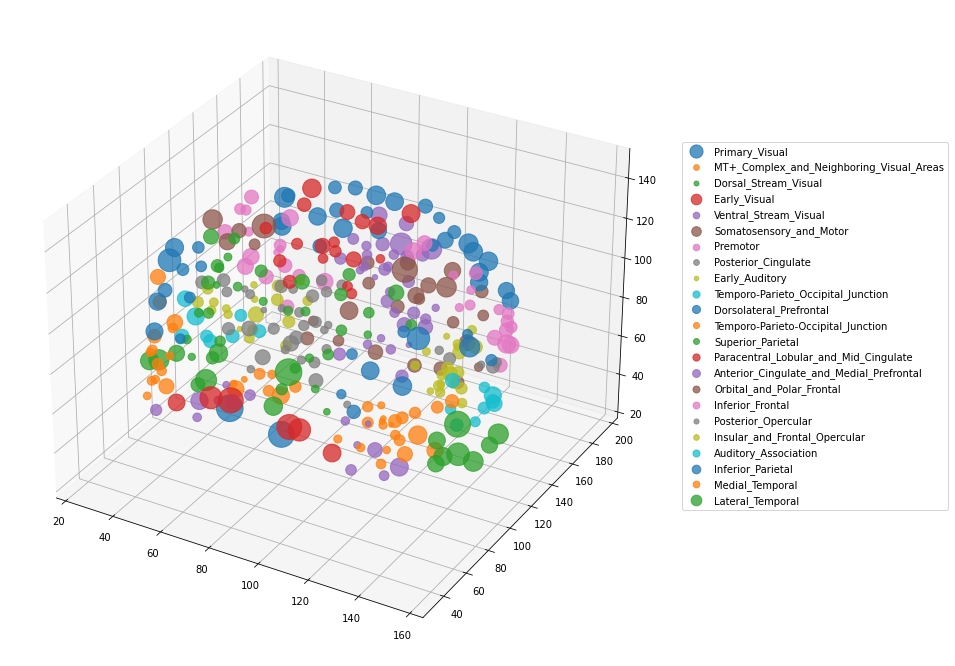

In [7]:
# Colour code the nodes in accordance to each collection
fig = plt.figure(figsize=(16,12))

ax = fig.add_subplot(projection='3d')

# Plot different colours based on labels:
collectionNames = cortexNames
collectionInds = cortexInds

for k in range(len(collectionNames)):
    inds = collectionInds[k]
    ax.scatter3D(X[inds], Y[inds], Z[inds], s=rads[inds], alpha=0.75)
    
ax.legend(
    collectionNames, 
    loc='upper right',
     markerscale=0.5, 
     bbox_to_anchor=(1.45,0.8))

# Configure parameters

In [8]:
# Euclidean distance matrix
dists = spatial.distance.cdist(coords, coords)

# Pairwise kernel function (vary this)
Kfun = lambda i,j, gamma: np.abs(deg[i] - deg[j])**gamma

# Pairwise probability function
eta = -1
eps = np.finfo(float).eps
Prob = lambda i,j: (dists[i,j] + eps)**eta # * Kfun(i,j,gamma)
probs = (dists + eps)**eta


# Define generator model

In [9]:
def GenerateAdjConnectome(dims, probs, options):
    '''
    Generate an adjacency matrix (i.e. a_ij = 1, 0) using pairwise probabilistic
    iteration of the kernel function ker_fun. Here, dims, is the dimensions of 
    the resulting connectome. options is a dictionary with the following
    attributes:
    - inds0: Indices i,j where we set a_ij = 0 at the beginning.
    - inds1: Indices i,j where we set a_ij = 1 at the beginning.
    - num_iters: The number of iterations conducted, up to the total
    number of entries available.
    
    Format inds0, inds1 as unraveled 1-d arrays.
    Use np.ravel_multi_index to revert back to 2-d row, col arrays.
    probs is a transform function from a standard uniform to the connectivity
    matrix.
    '''

    A = np.zeros(dims)
    inds0_flat = options['inds0']
    inds1_flat = options['inds1']
    
    # Random uniform matrix
    unif = np.random.uniform(size=dims)
    A = (unif < probs).astype('int64')

    # Set initial indices to 0
    if inds0_flat.size > 0:
        inds0 = np.unravel_index(inds0_flat, dims)
        A[inds0] = 0
    
    if inds1_flat.size > 0:
        inds1 = np.unravel_index(inds1_flat, dims)
        A[inds1] = 1

    return A

# TEST
dims = (360, 360)

inds0_flat = np.array([3,5,7,8]) # np.array([], dtype='int64')
inds1_flat = np.array([8,9,2,4]) # np.array([], dtype='int64')

options = {
    'inds0': inds0_flat,
    'inds1': inds1_flat,
    'num_iters': 100000
    }

A = GenerateAdjConnectome(dims, probs, options)
B = GenerateAdjConnectome(dims, probs, options)
np.count_nonzero(A)

2362

# Define probability kernels

In [10]:
def GetStatistics(adj):
    '''
    Using the adjacency matrix adj, acquire the following vectors to use with
    the probability kernel function:
    -  
    '''
    G = nx.from_numpy_matrix(adj)
    k = nx.degree(G)
    c = nx.clustering(G)
    s = nx.betweenness_centrality(G)

    return (k, c, s)

# Define parameter search

In [28]:
def SearchParameters(points, probs, sample_size):
    '''
    Given an array of points in parameter space with respective probabilities
    (energies), sample new parameter points near points based on their weighted
    probabilities.
    '''

    # Get minimum distance for each point (spherical radius)
    D = spatial.distance.cdist(points, points)

    # Radius, scaled so that the spheres slightly intersect
    rads = 1.2 * np.min(D, axis=0)

    # Determine which centers to use with multinomial distribution
    bin_samples = np.random.multinomial(sample_size, probs)
    
    # Sample parameter points:
    points_new = np.random.standard_normal((sample_size, points.shape[1]))
    
    # Normalize parameter point
    points_new = points_new / np.sum(points_new, axis=1)

    # Scale by random radius
    rads_new = np.random.uniform(size=sample_size)
    rads_new = rads_new * np.repeat(rads, bin_samples)

    points_new = rads_new * points_new

    # Center points_new at points
    points_new = points_new + np.repeat(points, bin_samples, axis=0)

    return points_new

# Test generator using different kernels

In [17]:
s = np.random.uniform(size=(2000, 3))
d = spatial.distance.cdist(s, s)
mind = np.min(d, axis=0)
mind.shape
# coords.shape

(2000,)

In [27]:
p = np.random.uniform(size=10)
p = p / np.sum(p)
s = np.random.multinomial(20, p)
np.repeat(np.arange(10), s), s

(array([0, 0, 1, 1, 2, 4, 4, 5, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8]),
 array([2, 2, 1, 0, 2, 1, 2, 5, 5, 0]))

In [ ]:
# Sample a point from all initial points using multi-bernoulli, 
# then use uniform distribution to determine
# the distance from the point.
trials = 78
for k in range(trials):
    X = GenerateAdjConnectome(dims, probs, options)
X


array([[1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int64)